In [5]:
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import LogNorm, ListedColormap
from matplotlib.ticker import MultipleLocator, ScalarFormatter

from scipy.stats import gaussian_kde


def standard_colormap() -> np.ndarray:
    hex_vals = [
        ("FF","FF","FF"),("00","00","FF"),("16","85","E9"),("87","A0","F8"),
        ("85","F7","FA"),("1A","E6","A4"),("20","E4","1B"),("97","EB","25"),
        ("D3","F8","07"),("F7","D3","31"),("FC","B5","6D"),("FF","80","80"),
        ("FF","00","00"),
    ]
    return np.array([[int(h,16)/255. for h in triple] for triple in hex_vals])


def prpd_histogram(t: np.ndarray,
                   phase: np.ndarray,
                   pdevents: np.ndarray,
                   pdMin: float,
                   pdMax: float,
                   bipolar: bool,
                   logarithmic: bool,
                   numXPoints: int,
                   numYPoints: int):
    """
    Build a PRPD histogram exactly like histogram.m

    Args:
        t           : 1D time vector
        phase       : 1D phase vector (0–1)
        pdevents    : 1D PD magnitude vector
        pdMin       : lower magnitude bound (was qMin)
        pdMax       : upper magnitude bound (was qMax)
        bipolar     : if True, center bipolar counts
        logarithmic : if True, use log10 scaling
        numXPoints  : width (# of phase bins)
        numYPoints  : height (# of magnitude bins)

    Returns:
        hist_counts : 2D array (numYPoints × numXPoints) of event rates
        hist_colors : 2D array of colormap indices (1‑based)
        hist_image  : hist_colors flipped vertically (for imshow)
    """
    maxy = numYPoints // (2 if bipolar else 1)

    if logarithmic:
        gain   = maxy / np.log10(pdMax / pdMin)
        offset = -np.log10(pdMin) * gain
    else:
        gain   = maxy / (pdMax - pdMin)
        offset = -pdMin * gain

    # truncate at first zero PD event
    zero_idx = np.nonzero(pdevents == 0)[0]
    n = zero_idx[0] if zero_idx.size else min(len(t), len(phase), len(pdevents))
    t        = t[:n]
    phase    = phase[:n]
    pdevents = pdevents[:n]
    dt       = t[-1] - t[0]

    # map to bin indices
    if logarithmic:
        mags = np.round(np.log10(np.abs(pdevents)) * gain + offset)
    else:
        mags = np.round((np.abs(pdevents) if not bipolar else pdevents) * gain + offset)

    xs = np.round(phase * (numXPoints - 1) + 1)
    mags = mags.astype(int)
    xs   = xs.astype(int)

    if logarithmic and bipolar:
        mags[pdevents < 0] *= -1

    if bipolar:
        mags = np.round(mags + numYPoints * 0.5).astype(int)

    # keep only valid bins
    mask = (mags > 0) & (mags <= numYPoints) & (xs > 0) & (xs <= numXPoints)
    mags = mags[mask] - 1
    xs   = xs[mask]   - 1

    # accumulate counts
    hist_counts = np.zeros((numYPoints, numXPoints), dtype=float)
    np.add.at(hist_counts, (mags, xs), 1)
    hist_counts /= dt

    # color indexing
    cm     = standard_colormap()
    numCol = cm.shape[0]
    hc     = np.zeros_like(hist_counts, dtype=int)

    mx = hist_counts.max()
    mn = hist_counts[hist_counts>0].min() if np.any(hist_counts>0) else 1.0
    m    = ((mx * 0.85) / mn)**(numCol/(numCol-1)) * mn
    root = (m/mn)**(1/numCol)
    prev = mx + 1

    for i in range(1, numCol+1):
        val = mn * root**(numCol - i)
        mask_i = (hist_counts >= val) & (hist_counts < prev)
        hc[mask_i] = numCol - i + 1
        prev = val

    hist_image = np.flipud(hc)
    return hist_counts, hc, hist_image


In [6]:
def import_pd_data(folder: str, q_unit: str) -> np.ndarray:
    """
    Import partial discharge data from a .PD file and return a single (N×2) array.

    Each 12-byte record contains:
      • bytes 0–3: float32 measurement q
      • bytes 4–11: float64 timestamp q_tm

    Args:
        folder: Path to the directory containing the .PD file.
        q_unit: Base filename (without “.PD”) to open.

    Returns:
        data: NumPy array of shape (N, 2), where
              data[:, 0] == q_tm (float64),
              data[:, 1] == q    (float32).
    """
    path = os.path.join(folder, f"{q_unit}.PD")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    # Read entire file
    with open(path, 'rb') as f:
        raw = f.read()

    L = len(raw)
    n_records = L // 12
    buf = np.frombuffer(raw, dtype=np.uint8, count=n_records*12)
    recs = buf.reshape(n_records, 12)

    # Extract measurement q (float32 from bytes 0–3)
    q = recs[:, 0:4].view('<f4').ravel()
    # Extract time   q_tm (float64 from bytes 4–11)
    q_tm = recs[:, 4:12].view('<f8').ravel()

    # Stack into one (N,2) array: [time, measurement]
    data = np.column_stack((q_tm, q))
    return data


In [7]:
def import_ph_data(folder: str, q_unit: str) -> np.ndarray:
    """
    Import phase‐position data from a .PH file.

    Each entry is a float64 in [0,1], where
      0 → 0° and 1 → 360° of the AC cycle.

    Args:
        folder: path to the directory containing the .PH file
        q_unit: base filename (without “.PH”) to open

    Returns:
        phase: 1D NumPy array of float64 phase positions
    """
    path = os.path.join(folder, f"{q_unit}.PH")
    if not os.path.isfile(path):
        raise FileNotFoundError(f"No such file: {path}")

    # Option 1: fast direct read
    phase = np.fromfile(path, dtype='<f8')

    # If you ever need degrees instead of fraction:
    # phase_degrees = phase * 360.0

    return phase


Folder : C:\Users\sapierso\Box\PD-Acoustic Project Data\3rd Party Export (MATLAB)\20250512_11h13m42s
Filename: MPD 800 2.1.1-20250416_12h33m10s365ms.PD


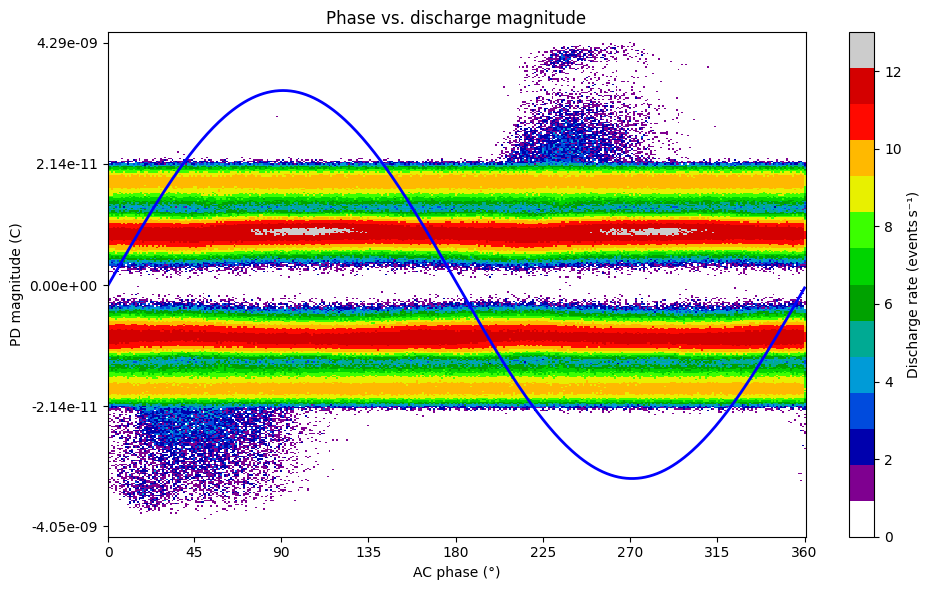

In [8]:
# Ask the user for a path (e.g. C:\Users\you\Documents\report.pdf)
filepath_str = input("Enter the full file path for the (.PD) file: ").strip().strip('"')

# Convert the string to a Path object
filepath = Path(filepath_str)

# Extract the directory (parent) and the file name separately
folder   = filepath.parent          # PosixPath or WindowsPath object
filename = filepath.name            # Just the file’s name with extension

print(f"Folder : {folder}")
print(f"Filename: {filename}")

data = import_pd_data(
    folder=folder,
    q_unit=filename.removesuffix('.PD')  # remove the file extension
)
phase = import_ph_data(folder, filename.removesuffix('.PD'))
t, pdevents = data[:,0], data[:,1]

nonzero = pdevents[pdevents != 0]
pdMin = np.min(np.abs(nonzero))
pdMax = np.max(np.abs(nonzero))

# build a PRPD
numXPoints=360
numYPoints=360
bipolar=True
logarithmic=True
counts, colors, img = prpd_histogram(
    t,          # time stamps
    phase,      # fractional phase data
    pdevents,   # PD magnitudes
    pdMin=pdMin,  # lower bound for magnitude
    pdMax=pdMax, # upper bound
    bipolar=bipolar,
    logarithmic=logarithmic,
    numXPoints=numXPoints,
    numYPoints=numYPoints
)

# # display
# plt.figure(figsize=(10,6))
# cmap = plt.matplotlib.colormaps['nipy_spectral'](np.linspace(0,1,standard_colormap().shape[0]))
# from matplotlib.colors import ListedColormap
# cmap = ListedColormap(cmap)
# plt.imshow(img, cmap=cmap)
# plt.colorbar(label='Colormap index')
# plt.xlabel('Phase bin')
# plt.ylabel('Magnitude bin')
# plt.title('PRPD Histogram')
# plt.show()

# 1) Recompute the exact gain/offset so we can invert
maxy = (numYPoints // 2) if bipolar else numYPoints
if logarithmic:
    gain   = maxy / np.log10(pdMax / pdMin)
    offset = -np.log10(pdMin) * gain
else:
    gain   = maxy / (pdMax - pdMin)
    offset = -pdMin * gain

# 2) Build a discrete colormap: first entry WHITE for zero‐counts,
#    then a spectral palette for nonzero event‐rates.
n_colors = standard_colormap().shape[0]  # e.g. 13
n_bins   = n_colors + 1                  # we need one extra for the zero‑count
base = plt.cm.nipy_spectral(np.linspace(0, 1, n_bins))
base[0] = [1,1,1,1]   # RGBA white for “no PD activity”
cmap = ListedColormap(base)

# 3) Plot
fig, ax = plt.subplots(figsize=(10,6))

# flip so row 0 is lowest‐magnitude
img = np.flipud(img)

# build bin‐edge vectors (one more element than bins, offset by 0.5)
x_edges = np.arange(numXPoints + 1) - 0.5
y_edges = np.arange(numYPoints + 1) - 0.5

# plot with pcolormesh
mesh = ax.pcolormesh(
    x_edges,
    y_edges,
    img,
    cmap=cmap,
    shading='auto',       # ensures correct alignment of cells
    vmin=0,
    vmax=n_bins-1,
)

# colorbar → event‐rate in physical units
cbar = fig.colorbar(mesh, ax=ax)
cbar.set_label("Discharge rate (events s⁻¹)")

# X‑axis → 0–360° of AC phase
ax.set_xlim(-0.5, numXPoints-0.5)
phase_ticks = np.linspace(0, numXPoints-1, 9, dtype=int)
phase_labels = np.linspace(0, 360, 9, dtype=int)
ax.set_xticks(phase_ticks)
ax.set_xticklabels(phase_labels)
ax.set_xlabel("AC phase (°)")

# Y‑axis → PD magnitude (including sign if bipolar=True)
bin_idx   = np.arange(numYPoints) + 1         # 1…numYPoints
shift     = (numYPoints / 2) if bipolar else 0
mags_pre  = bin_idx - shift                   # signed “scaled” bin
signs     = np.sign(mags_pre)
mags_abs  = np.abs(mags_pre)

if logarithmic:
    mag_vals = signs * 10**((mags_abs - offset) / gain)
else:
    mag_vals = signs * ((mags_abs - offset) / gain)

yticks = np.linspace(0, numYPoints-1, 5, dtype=int)
ylabels = [f"{mag_vals[i]:.2e}" for i in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
ax.set_ylabel("PD magnitude (C)")

# pad y‐limits
pad = 0.02 * numYPoints
ax.set_ylim(-0.5 - pad, numYPoints - 0.5 + pad)

# overlay sinusoid
x_sin = np.arange(numXPoints)
amp_bins = 0.8 * (numYPoints / 2)
center_bin = (numYPoints - 1) / 2
y_sin = center_bin + amp_bins * np.sin(2 * np.pi * x_sin / numXPoints)
ax.plot(x_sin, y_sin, linewidth=2, linestyle='-', color='blue')

# title & grids
ax.set_title("Phase vs. discharge magnitude")

plt.tight_layout()
plt.show()


In [9]:
# Ask user whether to make a video before execution
while True:
    make_video = input("Do you want to generate a PRPD video? (y/n): ").strip().lower()
    if make_video in ["y", "n"]:
        break
    print("Please enter 'y' or 'n'.")

if make_video == "y":
    # -----------------------------------
    # --- parameters you can tweak
    FPS          = 3        # output video frame-rate (<= 1/STEP keeps real-time)
    WINDOW_LEN   = 2.0      # s  – length of PRPD window
    STEP         = 1/FPS      # s  – hop between windows
    OUTFILE      = f"prpd_sliding_window_{FPS}fps.mp4"
    DPI          = 150
    # -----------------------------------

    # --------- PRE-COMPUTE CONSTANTS THAT MUST BE THE SAME FOR EVERY FRAME ---------
    nonzero = pdevents[pdevents != 0]
    pdMin   = np.min(np.abs(nonzero))
    pdMax   = np.max(np.abs(nonzero))

    numXPoints = 360
    numYPoints = 360
    bipolar    = True
    logarithmic = True

    # gain/offset for magnitude axis – identical to your static plot
    maxy = (numYPoints // 2) if bipolar else numYPoints
    if logarithmic:
        gain   = maxy / np.log10(pdMax / pdMin)
        offset = -np.log10(pdMin) * gain
    else:
        gain   = maxy / (pdMax - pdMin)
        offset = -pdMin * gain

    # build discrete colour-map once
    n_colors = standard_colormap().shape[0]
    base     = plt.cm.nipy_spectral(np.linspace(0, 1, n_colors + 1))
    base[0]  = [1, 1, 1, 1]                       # white for zero-counts
    cmap     = ListedColormap(base)
    vmin, vmax = 0, n_colors                      # for pcolormesh normalisation

    # sin-wave overlay – X positions never change
    x_sin       = np.arange(numXPoints)
    amp_bins    = 0.8 * (numYPoints / 2)
    center_bin  = (numYPoints - 1) / 2
    y_sin_fixed = center_bin + amp_bins * np.sin(2 * np.pi * x_sin / numXPoints)

    # pcolormesh bin edges (identical each frame)
    x_edges = np.arange(numXPoints + 1) - 0.5
    y_edges = np.arange(numYPoints + 1) - 0.5
    # -----------------------------------------------------------------------------

    # ------- figure & axes set-up (done only once) -------------------------------
    fig, ax = plt.subplots(figsize=(10, 6), dpi=DPI)
    mesh = ax.pcolormesh(x_edges, y_edges,               # dummy 2-D array now; real data later
                        np.zeros((numYPoints, numXPoints)),
                        cmap=cmap, shading="auto", vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mesh, ax=ax)
    cbar.set_label("Discharge rate (events s⁻¹)")

    # X axis labelling (0–360°)
    ax.set_xlim(-0.5, numXPoints - 0.5)
    phase_ticks   = np.linspace(0, numXPoints - 1, 9, dtype=int)
    phase_labels  = np.linspace(0, 360, 9, dtype=int)
    ax.set_xticks(phase_ticks)
    ax.set_xticklabels(phase_labels)
    ax.set_xlabel("AC phase (°)")

    # Y axis ticks: build once, apply every frame
    bin_idx   = np.arange(numYPoints) + 1
    shift     = (numYPoints / 2) if bipolar else 0
    mags_pre  = bin_idx - shift
    signs     = np.sign(mags_pre)
    mags_abs  = np.abs(mags_pre)
    if logarithmic:
        mag_vals = signs * 10 ** ((mags_abs - offset) / gain)
    else:
        mag_vals = signs * ((mags_abs - offset) / gain)
    yticks   = np.linspace(0, numYPoints - 1, 5, dtype=int)
    ylabels  = [f"{mag_vals[i]:.2e}" for i in yticks]
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_ylabel("PD magnitude (C)")

    ax.set_title("Sliding-window PRPD histogram")
    pad = 0.02 * numYPoints
    ax.set_ylim(-0.5 - pad, numYPoints - 0.5 + pad)

    # static sinusoid overlay
    sin_line, = ax.plot(x_sin, y_sin_fixed, lw=2, color="blue")
    plt.tight_layout()
    # -----------------------------------------------------------------------------


    # --------------------------- THE ANIMATION CORE ------------------------------
    def frame_generator():
        """Yield successive (start, stop) indices into the data arrays."""
        t0 = t.min()
        t_end = t.max() - WINDOW_LEN
        starts = np.arange(t0, t_end + 1e-9, STEP)
        for s in starts:
            mask = (t >= s) & (t < s + WINDOW_LEN)
            yield mask, s

    def init():                                       # optional; nothing to reset
        return (mesh,)

    def update(frame):
        mask, start_time = frame
        # nothing to draw if window empty – skip
        if not np.any(mask):
            return (mesh,)

        # build PRPD histogram for the window
        counts, _, img = prpd_histogram(
            t[mask], phase[mask], pdevents[mask],
            pdMin=pdMin, pdMax=pdMax,
            bipolar=bipolar, logarithmic=logarithmic,
            numXPoints=numXPoints, numYPoints=numYPoints,
        )

        img = np.flipud(img)                          # row 0 = lowest magnitude
        mesh.set_array(img.ravel())                   # *fast* update of pcolormesh
        ax.set_title(f"PRPD   t = {start_time:7.2f} – {start_time + WINDOW_LEN:7.2f} s")
        return (mesh,)

    # build the animation
    anim = animation.FuncAnimation(
        fig, update, frames=frame_generator,
        init_func=init, blit=True, interval=1000/FPS
    )

    # ----------------------------- EXPORT TO DISK --------------------------------
    #  (requires `ffmpeg` in PATH – on Windows install the static build and
    #   add the bin folder to your environment variables.)
    writer = animation.FFMpegWriter(fps=FPS, bitrate=1800)
    anim.save(OUTFILE, writer=writer)
    print(f"Video saved to {OUTFILE}")
